In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Load data
df = pd.read_csv('master_csv_0.csv')

# Choose features
imu_features = [
    'accel_x_filtered', 'accel_z_filtered', 'gyro_y_filtered', 'gyro_z_filtered'
]
target_column = 'filtered_emg'

imu_segments = []
emg_segments = []

# Loop over unique segments
for segment_uid in df['Segment UID'].unique():
    segment_df = df[df['Segment UID'] == segment_uid]

    # Extract IMU and EMG data
    imu_data = segment_df[imu_features].values
    emg_data = segment_df[target_column].values

    # Store them as separate entries
    imu_segments.append(imu_data)
    emg_segments.append(emg_data)


Shape after polynomial expansion: (26568, 34)
Validation RMSE: 15.6250
Validation R²: -0.0001


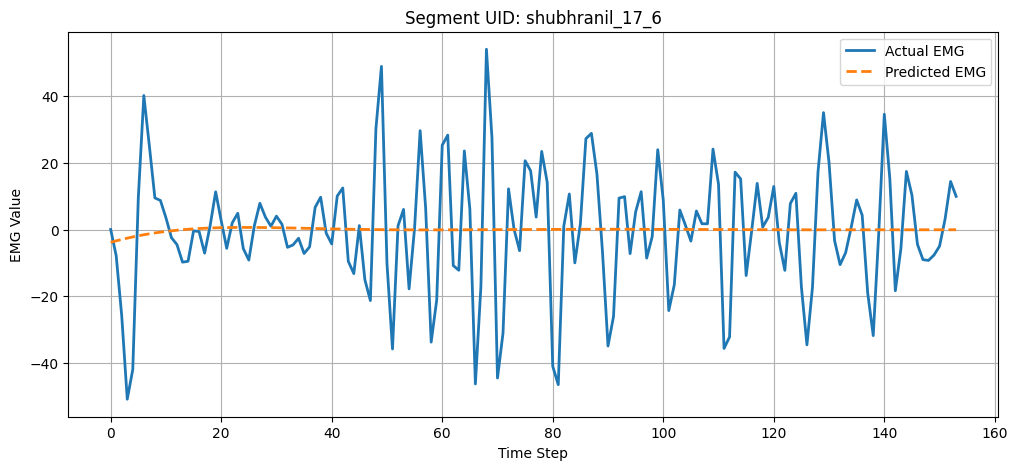

In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score

# 1️⃣ Shuffle and Split Segments
all_segments = np.array(df['Segment UID'].unique())
np.random.shuffle(all_segments)

n_total = len(all_segments)
n_train = int(0.8 * n_total)
n_val = int(0.1 * n_total)

train_segments = all_segments[:n_train]
val_segments = all_segments[n_train:n_train+n_val]
test_segments = all_segments[n_train+n_val:]

# 2️⃣ Stack Data
def stack_segments(segments, all_segments, imu_segments, emg_segments):
    X = np.vstack([imu_segments[i] for i, seg in enumerate(all_segments) if seg in segments])
    y = np.hstack([emg_segments[i] for i, seg in enumerate(all_segments) if seg in segments])
    return X, y

X_train, y_train = stack_segments(train_segments, all_segments, imu_segments, emg_segments)
X_val, y_val = stack_segments(val_segments, all_segments, imu_segments, emg_segments)
X_test, y_test = stack_segments(test_segments, all_segments, imu_segments, emg_segments)

# 3️⃣ Scale IMU features
imu_scaler = StandardScaler()
X_train_scaled = imu_scaler.fit_transform(X_train)
X_val_scaled = imu_scaler.transform(X_val)
X_test_scaled = imu_scaler.transform(X_test)

# 4️⃣ Scale EMG targets
emg_scaler = StandardScaler()
y_train_scaled = emg_scaler.fit_transform(y_train.reshape(-1,1)).flatten()
y_val_scaled = emg_scaler.transform(y_val.reshape(-1,1)).flatten()
y_test_scaled = emg_scaler.transform(y_test.reshape(-1,1)).flatten()

# 5️⃣ Apply Polynomial Expansion (degree=3)
poly = PolynomialFeatures(degree=3, include_bias=False)
X_train_poly = poly.fit_transform(X_train_scaled)
X_val_poly = poly.transform(X_val_scaled)
X_test_poly = poly.transform(X_test_scaled)

print(f"Shape after polynomial expansion: {X_train_poly.shape}")

# 6️⃣ Train Ridge Regression
model = Ridge(alpha=1.0)
model.fit(X_train_poly, y_train_scaled)

# 7️⃣ Evaluate Model
y_val_pred_scaled = model.predict(X_val_poly)
y_val_pred = emg_scaler.inverse_transform(y_val_pred_scaled.reshape(-1,1)).flatten()

rmse_val = root_mean_squared_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation R²: {r2_val:.4f}")

# 8️⃣ Plot Predictions for a Specific Segment
def plot_segment_prediction(model, segment_uid, all_segments, imu_segments, emg_segments, imu_scaler, emg_scaler, poly):
    segment_idx = np.where(all_segments == segment_uid)[0][0]

    # Scale IMU features
    imu_data = imu_segments[segment_idx]
    imu_data_scaled = imu_scaler.transform(imu_data)
    imu_data_poly = poly.transform(imu_data_scaled)

    # Predict scaled EMG
    emg_pred_scaled = model.predict(imu_data_poly)
    emg_pred = emg_scaler.inverse_transform(emg_pred_scaled.reshape(-1,1)).flatten()

    # Plot
    plt.figure(figsize=(12, 5))
    plt.plot(emg_segments[segment_idx], label='Actual EMG', linewidth=2)
    plt.plot(emg_pred, label='Predicted EMG', linestyle='--', linewidth=2)
    plt.title(f"Segment UID: {segment_uid}")
    plt.xlabel("Time Step")
    plt.ylabel("EMG Value")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
example_segment = all_segments[0]  # or pick any from val/test set
plot_segment_prediction(model, example_segment, all_segments, imu_segments, emg_segments, imu_scaler, emg_scaler, poly)
